In [1]:
#meta 5/16/2022 ARIMA Model for Time Series Forecasting in Python - Compare Models (diff hparams)
#Author: Jason Brownlee on January 9, 2017
# src https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
#best to use with my another tutorial
# refer to https://github.com/anyaconda/myStats/blob/master/myTutorial_TimeSeriesForecasting_ARIMA.ipynb

#run my WLaptop
#infra: my WLaptop w/ data in csv file
#default py3 env
#pandas 1.0.3, numpy 1.21.0

#started from tutorial_ARIMA_TimeSeriesForecasting.ipynb
#input: my_data/timeseries.csv 
#output: n/a

#history
# 5/18/2022 EXTEND INITIAL TUTORIAL - COMPARE MODELS (DIFF HPARAMS) MANUALLY
#      Same tutorial 
#      if convergence $error, check model_fit.mle_retvals
#next try predict() insted of forecast()

#References
#strptime()
# refer to https://www.programiz.com/python-programming/datetime/strptime

In [2]:
import numpy as np
import pandas as pd
import time #to track performance time
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA

In [21]:
#python version $my
import sys
print(sys.version)
print(pd.__version__, np.__version__)

3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
1.0.3 1.21.0


In [3]:
#-------- GLOBAL VARS --------
plt.rcParams['figure.figsize'] = (20, 8)

CSV_PATH = "my_data/timeseries.csv"

# ARIMA Model for Time Series Forecasting
based on Jason Brownlee post

## 0. Load dataset
Time series dataset with figures from 1991 to 2008 period.

In [4]:
series = pd.read_csv(CSV_PATH, header=0, index_col=0, parse_dates=True, squeeze=True)
print(series.shape)
series.head()

(204,)


date
1991-07-01    3.526591
1991-08-01    3.180891
1991-09-01    3.252221
1991-10-01    3.611003
1991-11-01    3.565869
Name: value, dtype: float64

In [5]:
series.index = series.index.to_period('M')
series.head()

date
1991-07    3.526591
1991-08    3.180891
1991-09    3.252221
1991-10    3.611003
1991-11    3.565869
Freq: M, Name: value, dtype: float64

### 0.1 EDA

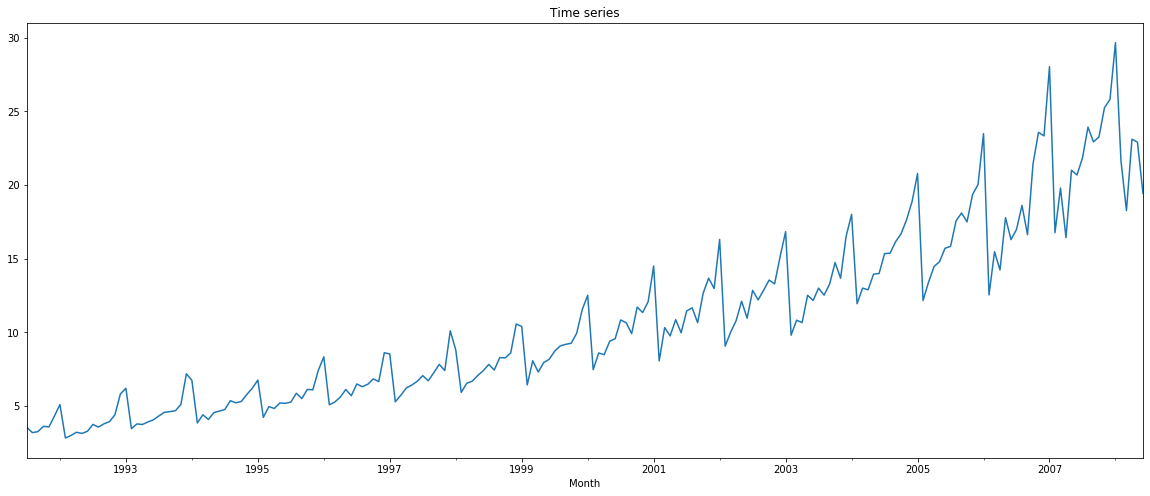

In [6]:
# vis data
series.plot(title = 'Time series')
plt.xlabel("Month")
plt.show()

The dataset has a clear trend -> Modeling: suggests that the time series is not stationary and will require differencing to make it stationary, at least a difference order of 1.

#### Vis Autocorrelation

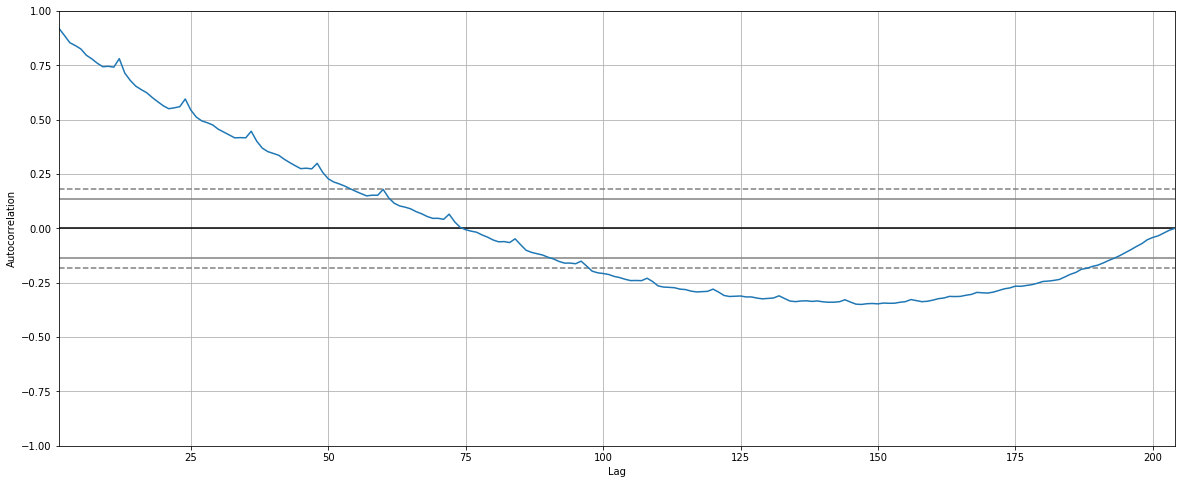

In [7]:
#plots the autocorrelation for a large number of lags in ts
autocorrelation_plot(series)
plt.show()

$todo: interpret

refer to https://github.com/anyaconda/myStats/blob/master/myTutorial_TimeSeriesForecasting_ARIMA.ipynb

## 2. How to Model
statsmodels library provides the capability to fit an ARIMA model.

### 2.0 Fit an ARIMA model
fit an ARIMA model to the entire dataset and review the residual errors.

`ARIMA(p,d,q)` model parameters:

- AR set the lag value to p for autoregression  
- I use a difference order of 1 to make the time series stationary  
- MA use a moving average model of q

In [8]:
# fit model
ORDER_P = 5
ORDER_D = 1
ORDER_Q = 0

model = ARIMA(series, order=(ORDER_P,ORDER_D,ORDER_Q))
model_fit = model.fit()

# summary of fit model
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  204
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -428.842
Date:                Thu, 04 Aug 2022   AIC                            869.685
Time:                        17:00:26   BIC                            889.564
Sample:                    07-31-1991   HQIC                           877.727
                         - 06-30-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4858      0.057     -8.462      0.000      -0.598      -0.373
ar.L2         -0.2710      0.066     -4.130      0.000      -0.400      -0.142
ar.L3         -0.2580      0.073     -3.540      0.0

Summarizes the coefficient values used as well as the skill of the fit on the on the in-sample observations.

#### Check model
Class to hold results from fitting a state space model https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.mlemodel.MLEResults.html#statsmodels.tsa.statespace.mlemodel.MLEResults

In [9]:
model_fit.mle_retvals

{'fopt': 2.1021680835187646,
 'gopt': array([ 1.64885883e-06, -1.50279789e-06,  4.08117984e-08, -6.58584298e-07,
        -2.22488694e-07,  1.23012711e-07]),
 'fcalls': 56,
 'warnflag': 0,
 'converged': True,
 'iterations': 5}

#### Residual errors

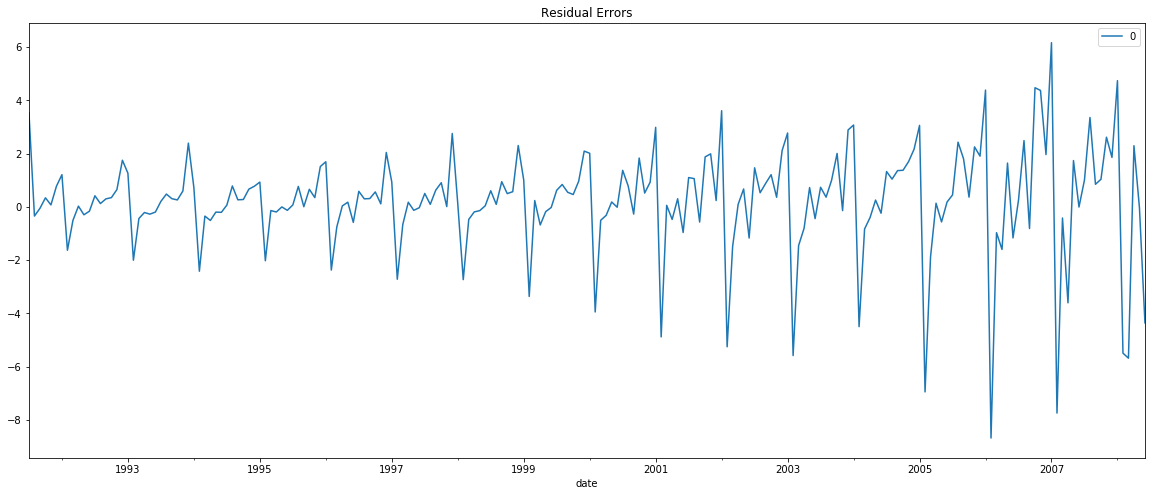

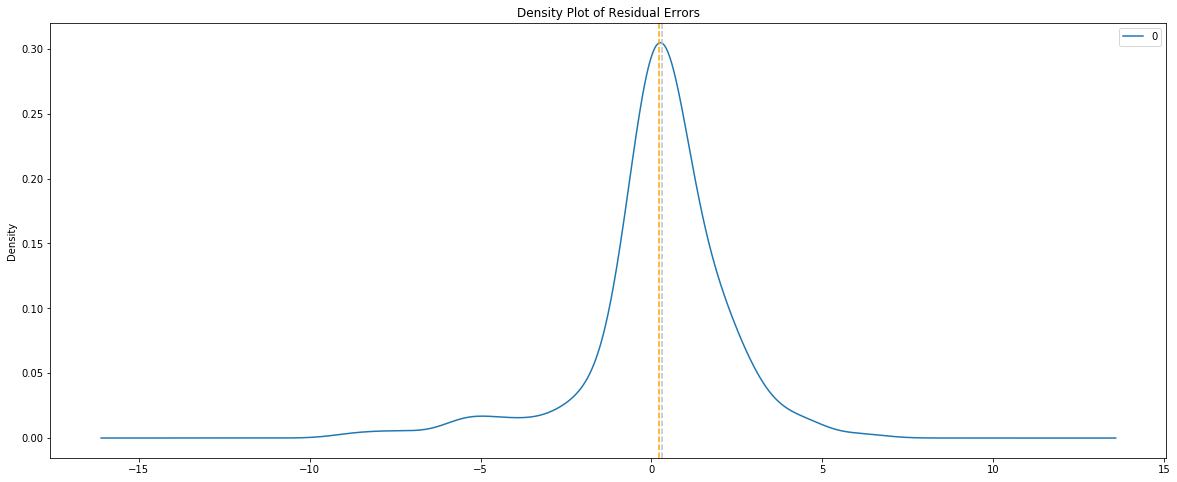

In [10]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title = 'Residual Errors')
plt.show()

# density plot of residuals
residuals.plot(kind='kde', title = 'Density Plot of Residual Errors')
plt.axvline(residuals.describe().loc['mean',0], color ='orange', linestyle ='--')
plt.axvline(residuals.describe().loc['50%',0], color ='silver', linestyle ='--')
plt.show()

- Line plot of the residual errors suggests $tolearn that there may still be some trend information not captured by the model
- Density plot of the residual errors suggests the errors are Gaussian (centered close to zero)

In [11]:
# summary stats of residuals
print(residuals.describe())

                0
count  204.000000
mean     0.214424
std      2.002684
min     -8.678838
25%     -0.272631
50%      0.299292
75%      1.036104
max      6.162016


The results show that indeed there is a close to zero mean in the residuals.

## 1. Prep data
We used the entire dataset for time series analysis, ideally we would perform this analysis on just the training dataset when developing a predictive model.

In [12]:
# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]

print(len(train), len(test))

134 70


### 2.1 Create a Model
ARIMA modeling to make forecasts

`forecast()` function performs a one-step forecast using the model

A rolling forecast is required given the dependence on observations in prior time steps for differencing and the AR model. A crude way to perform this rolling forecast is to re-create the ARIMA model after each new observation is received.

#### Model a)

In [13]:
# 1)fit the model on train ds, and 2)generate a prediction for each element on the test ds
history = [x for x in train]
predictions = list()

#track overall training time
t0 = time.time()

# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(ORDER_P,ORDER_D,ORDER_Q))
	model_fit = model.fit() #method_kwargs={"warn_convergence": False}
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

print("Modeling time (in min): ", (time.time() - t0)/60)

predicted=11.667852, expected=12.854748
predicted=12.247743, expected=13.542004
predicted=12.874914, expected=13.287640
predicted=12.807301, expected=15.134918
predicted=14.065333, expected=16.828350
predicted=15.214122, expected=9.800215
predicted=12.282987, expected=10.816994
predicted=12.185490, expected=10.654223
predicted=11.591198, expected=12.512323
predicted=12.937992, expected=12.161210
predicted=12.763152, expected=12.998046
predicted=11.974856, expected=12.517276
predicted=12.110086, expected=13.268658
predicted=12.552221, expected=14.733622
predicted=13.737776, expected=13.669382
predicted=13.420717, expected=16.503966
predicted=14.961294, expected=18.003768
predicted=16.199102, expected=11.938030
predicted=13.646054, expected=12.997900
predicted=13.884453, expected=12.882645
predicted=13.326100, expected=13.943447
predicted=14.472542, expected=13.989472
predicted=14.428020, expected=15.339097
predicted=14.164121, expected=15.370764
predicted=14.597529, expected=16.142005
p

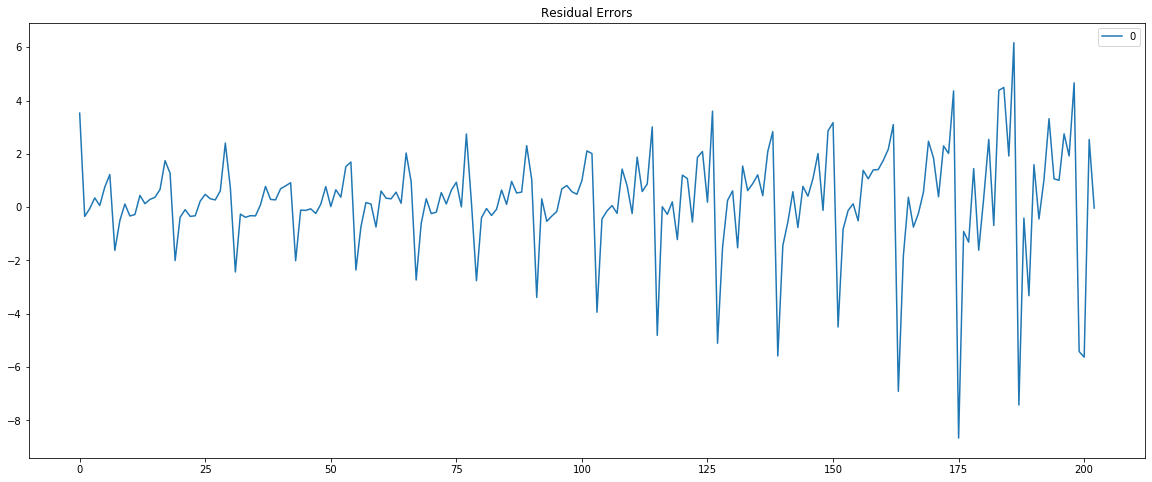

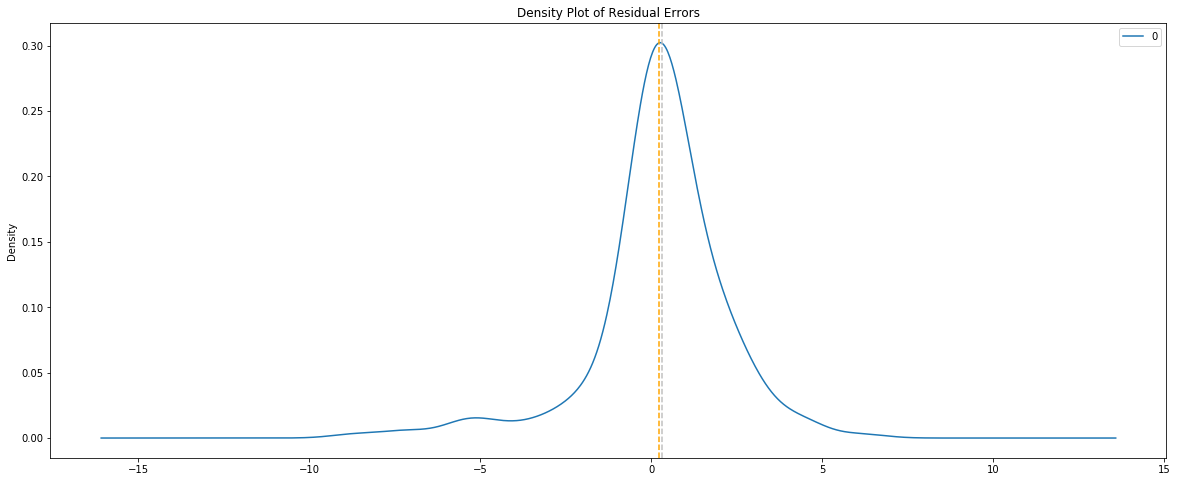

In [14]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title = 'Residual Errors')
plt.show()

# density plot of residuals
residuals.plot(kind='kde', title = 'Density Plot of Residual Errors')
plt.axvline(residuals.describe().loc['mean',0], color ='orange', linestyle ='--')
plt.axvline(residuals.describe().loc['50%',0], color ='silver', linestyle ='--')
plt.show()

In [15]:
# summary stats of residuals
print(residuals.describe())

                0
count  203.000000
mean     0.244731
std      1.977104
min     -8.662470
25%     -0.322044
50%      0.314809
75%      1.066169
max      6.170014


#### Evaluate Model
Calculate RMSE for the predictions, providing a point of comparison for other ARIMA configurations

Test RMSE: 3.000


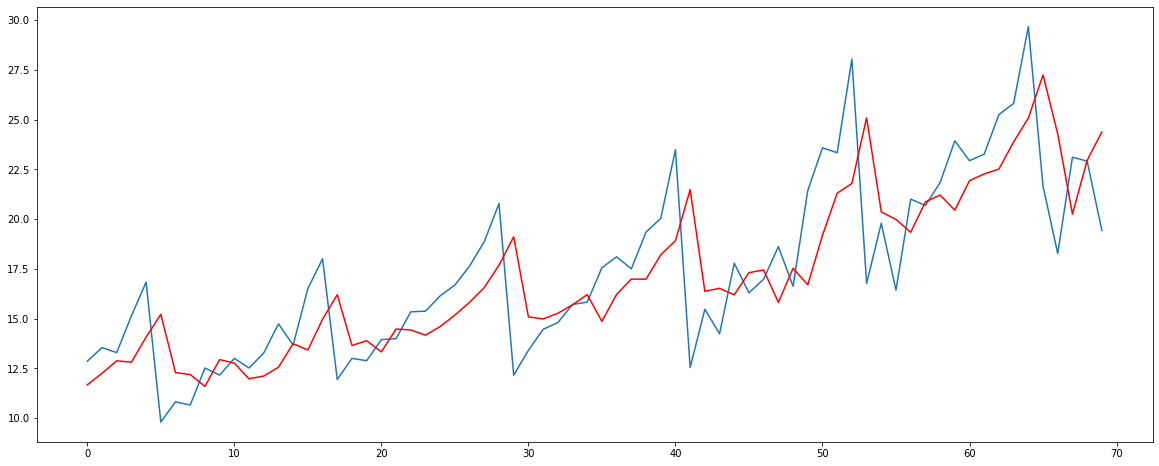

In [16]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

Plot shows the expected values (blue) compared to the rolling forecast predictions (red). We can see the values show some trend and are in the correct scale.

The model could use further tuning of the `p`, `d`, and maybe even the `q` parameters.

#### Model b)
Try diff hparams

In [17]:
ORDER_P = 10

# 1)fit the model on train ds, and 2)generate a prediction for each element on the test ds
history = [x for x in train]
predictions = list()

#track overall training time
t0 = time.time()

# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(ORDER_P,ORDER_D,ORDER_Q))
	model_fit = model.fit() #method_kwargs={"warn_convergence": False}
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

print("Modeling time (in min): ", (time.time() - t0)/60)

predicted=11.986703, expected=12.854748
predicted=12.865230, expected=13.542004
predicted=13.203687, expected=13.287640
predicted=13.370918, expected=15.134918
predicted=12.585474, expected=16.828350
predicted=14.132527, expected=9.800215
predicted=11.622188, expected=10.816994
predicted=11.898948, expected=10.654223
predicted=11.044623, expected=12.512323
predicted=12.739266, expected=12.161210
predicted=12.622410, expected=12.998046
predicted=12.309444, expected=12.517276
predicted=12.871777, expected=13.268658
predicted=12.944962, expected=14.733622
predicted=14.434551, expected=13.669382
predicted=14.084536, expected=16.503966
predicted=13.421787, expected=18.003768
predicted=15.023614, expected=11.938030
predicted=12.541542, expected=12.997900
predicted=13.351888, expected=12.882645
predicted=12.626620, expected=13.943447
predicted=13.854054, expected=13.989472
predicted=13.797842, expected=15.339097
predicted=13.929260, expected=15.370764
predicted=14.860623, expected=16.142005
p

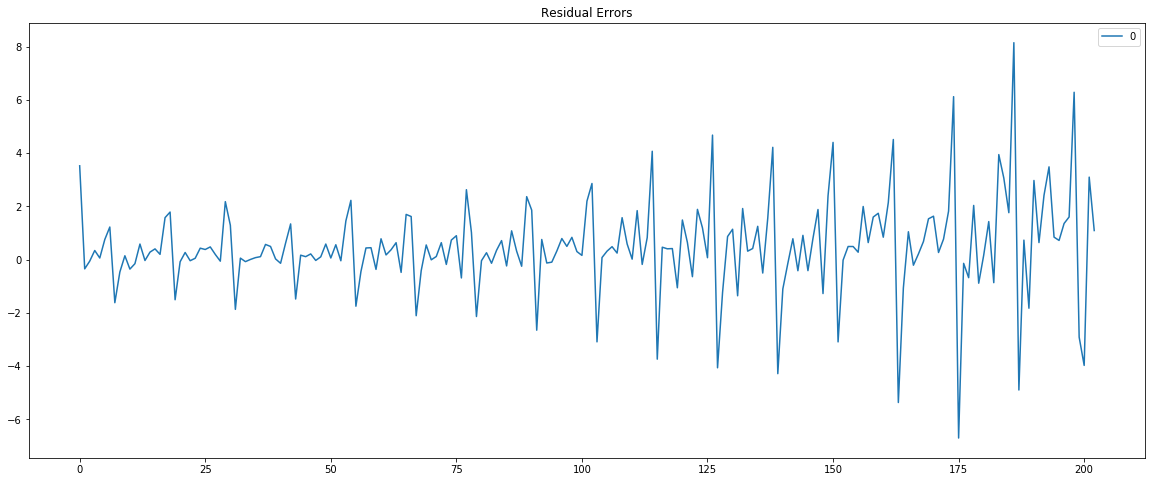

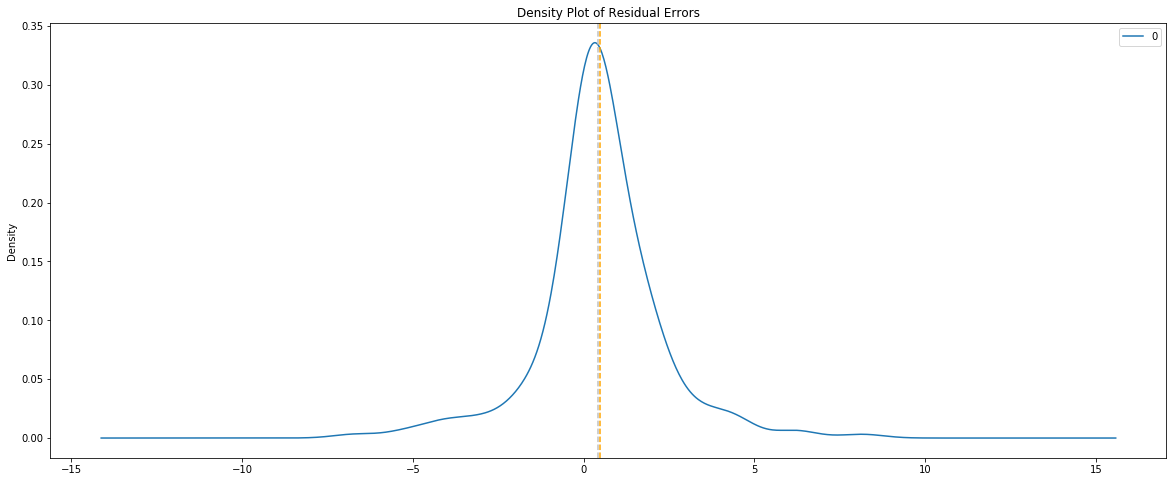

In [18]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(title = 'Residual Errors')
plt.show()

# density plot of residuals
residuals.plot(kind='kde', title = 'Density Plot of Residual Errors')
plt.axvline(residuals.describe().loc['mean',0], color ='orange', linestyle ='--')
plt.axvline(residuals.describe().loc['50%',0], color ='silver', linestyle ='--')
plt.show()

In [19]:
# summary stats of residuals
print(residuals.describe())

                0
count  203.000000
mean     0.472083
std      1.800883
min     -6.702685
25%     -0.109869
50%      0.404783
75%      1.210272
max      8.152635


#### Evaluate Model
Calculate RMSE for the predictions, providing a point of comparison for other ARIMA configurations

Test RMSE: 2.911


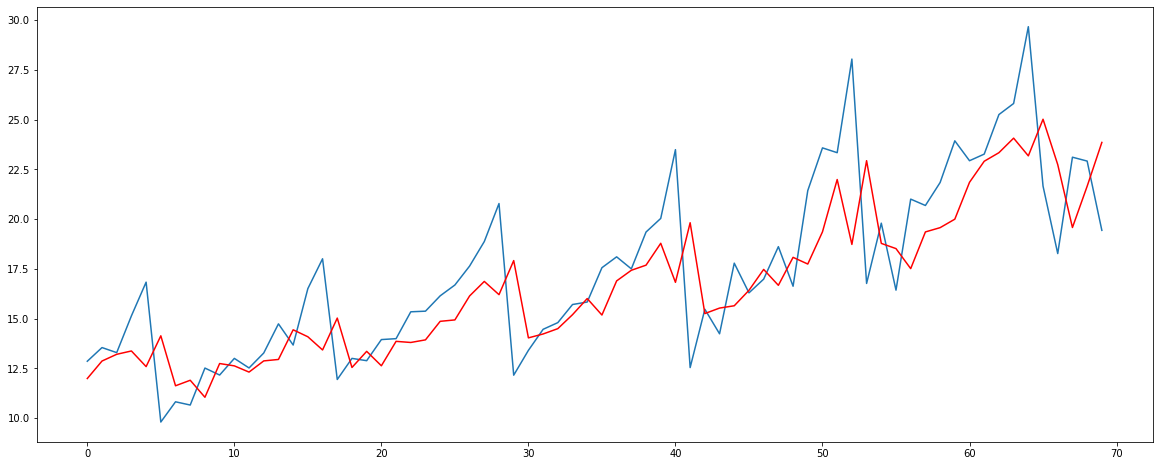

In [20]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

#### Compare results
which hparams performed better?